In [57]:
import json
import pandas as pd
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt

@dataclass
class Trade:
    timestamp: int
    buyer: str
    seller: str
    symbol: str
    currency: str
    price: float
    quantity: int

# Read entire log file
with open('/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round3/eda/round3_results/round_3_results.log', 'r') as f:
    content = f.read()

# --- Parse Sandbox Logs ---
sandbox_start = content.find('Sandbox logs:')
activities_start = content.find('Activities log:')
sandbox_section = content[sandbox_start + len('Sandbox logs:'):activities_start].strip()

# Each JSON object is on a new line; wrap in array brackets
# sandbox_json = '[' + ','.join(sandbox_section.split('\n')) + ']'

# sandbox_logs = json.loads(sandbox_json)

# --- Parse Activities Log ---
trades_start = content.find('Trade History:')
activities_section = content[activities_start + len('Activities log:'):trades_start].strip()

# Read CSV section into a DataFrame
from io import StringIO
activities_df = pd.read_csv(StringIO(activities_section), sep=';')

# --- Parse Trades ---
trades_section = content[trades_start + len('Trade History:'):].strip()
trades_data = json.loads(trades_section)

# Convert to Trade objects
trades: List[Trade] = [Trade(**t) for t in trades_data]

In [74]:
activities_df[activities_df["product"] == "VOLCANIC_ROCK"]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
7,3,0,VOLCANIC_ROCK,10165.0,209.0,NaN,NaN,NaN,NaN,10167,148,10168.0,61.0,NaN,NaN,10166.0,0.00000
17,3,100,VOLCANIC_ROCK,10164.0,114.0,10163.0,57.0,NaN,NaN,10165,114,10166.0,57.0,NaN,NaN,10164.5,-113.90625
40,3,200,VOLCANIC_ROCK,10168.0,135.0,10167.0,57.0,NaN,NaN,10170,192,NaN,NaN,NaN,NaN,10169.0,-24.06250
47,3,300,VOLCANIC_ROCK,10169.0,138.0,10168.0,43.0,NaN,NaN,10170,138,10171.0,43.0,NaN,NaN,10169.5,-75.31250
66,3,400,VOLCANIC_ROCK,10171.0,128.0,10170.0,44.0,NaN,NaN,10173,172,NaN,NaN,NaN,NaN,10172.0,-14.15625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139935,3,999500,VOLCANIC_ROCK,9915.0,141.0,9914.0,66.0,NaN,NaN,9917,207,NaN,NaN,NaN,NaN,9916.0,96454.50000
139956,3,999600,VOLCANIC_ROCK,9916.0,119.0,9915.0,75.0,NaN,NaN,9918,194,NaN,NaN,NaN,NaN,9917.0,95986.75000
139960,3,999700,VOLCANIC_ROCK,9917.0,115.0,9916.0,53.0,NaN,NaN,9918,115,9919.0,53.0,NaN,NaN,9917.5,95686.75000
139979,3,999800,VOLCANIC_ROCK,9918.0,127.0,9917.0,46.0,NaN,NaN,9920,164,NaN,NaN,NaN,NaN,9919.0,95272.75000


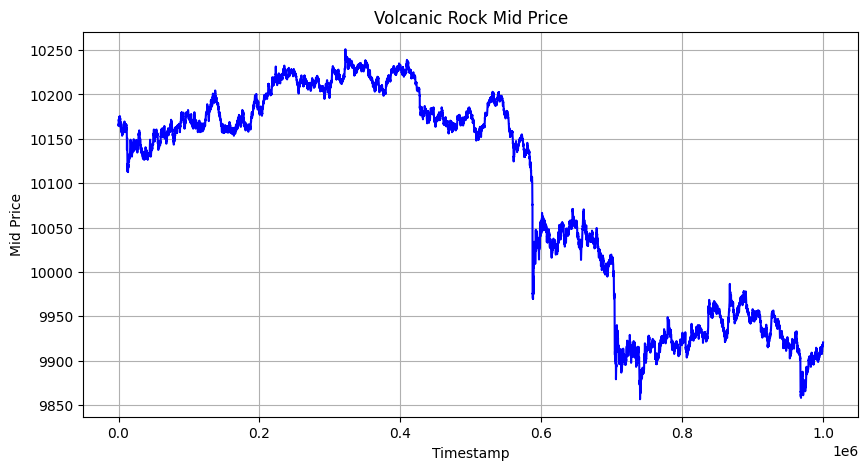

In [75]:
# plot volcanic rock midprice
plt.figure(figsize=(10, 5))
plt.plot(activities_df[activities_df["product"] == "VOLCANIC_ROCK"]['timestamp'], activities_df[activities_df["product"] == "VOLCANIC_ROCK"]['mid_price'], label='Mid Price', color='blue')
plt.title('Volcanic Rock Mid Price')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.grid()



In [77]:
our_trades = [trade for trade in trades if trade.buyer == "SUBMISSION" or trade.seller == "SUBMISSION"]
# Convert to DataFrame
trades_df = pd.DataFrame([trade.__dict__ for trade in our_trades])
print(trades_df[trades_df['symbol'].str.contains('VOLCANIC_ROCK_VOUCHER')])

print(len(trades_df))


      timestamp       buyer      seller                       symbol  \
0             0  SUBMISSION              VOLCANIC_ROCK_VOUCHER_10500   
1             0  SUBMISSION              VOLCANIC_ROCK_VOUCHER_10500   
2             0              SUBMISSION   VOLCANIC_ROCK_VOUCHER_9750   
3             0              SUBMISSION  VOLCANIC_ROCK_VOUCHER_10000   
5             0              SUBMISSION   VOLCANIC_ROCK_VOUCHER_9500   
...         ...         ...         ...                          ...   
7546     741000              SUBMISSION  VOLCANIC_ROCK_VOUCHER_10500   
7638     758400              SUBMISSION  VOLCANIC_ROCK_VOUCHER_10500   
7670     765700              SUBMISSION  VOLCANIC_ROCK_VOUCHER_10500   
7671     765700              SUBMISSION  VOLCANIC_ROCK_VOUCHER_10500   
7703     770800              SUBMISSION  VOLCANIC_ROCK_VOUCHER_10500   

       currency  price  quantity  
0     SEASHELLS      4        14  
1     SEASHELLS      4         2  
2     SEASHELLS    417        

In [59]:
#last mid price
print(activities_df[activities_df['product'] == 'RAINFOREST_RESIN']['mid_price'].iloc[-1])

10000.0


In [60]:
symbols = ["RAINFOREST_RESIN", "KELP", "SQUID_INK", "CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"]

rfr_trades = [trade for trade in trades if trade.symbol == 'RAINFOREST_RESIN']
kelp_trades = [trade for trade in trades if trade.symbol == 'KELP']
squid_ink_trades = [trade for trade in trades if trade.symbol == 'SQUID_INK']
croissants_trades = [trade for trade in trades if trade.symbol == 'CROISSANTS']
jams_trades = [trade for trade in trades if trade.symbol == 'JAMS']
djembes_trades = [trade for trade in trades if trade.symbol == 'DJEMBES']
pic1_trades = [trade for trade in trades if trade.symbol == 'PICNIC_BASKET1']
pic2_trades = [trade for trade in trades if trade.symbol == 'PICNIC_BASKET2']
volcanic_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK']
volcanic_rock_voucher_9500_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK_VOUCHER_9500']
volcanic_rock_voucher_9750_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK_VOUCHER_9750']
volcanic_rock_voucher_10000_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK_VOUCHER_10000']
volcanic_rock_voucher_10250_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK_VOUCHER_10250']
volcanic_rock_voucher_10500_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK_VOUCHER_10500']



# our trades
rfr_buys = [trade for trade in rfr_trades if trade.buyer == 'SUBMISSION']
rfr_sells = [trade for trade in rfr_trades if trade.seller == 'SUBMISSION']
outstanding_rfr_position = sum(trade.quantity for trade in rfr_buys) - sum(trade.quantity for trade in rfr_sells)

kelp_buys = [trade for trade in kelp_trades if trade.buyer == 'SUBMISSION']
kelp_sells = [trade for trade in kelp_trades if trade.seller == 'SUBMISSION']
outstanding_kelp_position = sum(trade.quantity for trade in kelp_buys) - sum(trade.quantity for trade in kelp_sells)

squid_ink_buys = [trade for trade in squid_ink_trades if trade.buyer == 'SUBMISSION']
squid_ink_sells = [trade for trade in squid_ink_trades if trade.seller == 'SUBMISSION']
outstanding_squid_ink_position = sum(trade.quantity for trade in squid_ink_buys) - sum(trade.quantity for trade in squid_ink_sells)

croissants_buys = [trade for trade in croissants_trades if trade.buyer == 'SUBMISSION']
croissants_sells = [trade for trade in croissants_trades if trade.seller == 'SUBMISSION']
outstanding_croissants_position = sum(trade.quantity for trade in croissants_buys) - sum(trade.quantity for trade in croissants_sells)

jams_buys = [trade for trade in jams_trades if trade.buyer == 'SUBMISSION']
jams_sells = [trade for trade in jams_trades if trade.seller == 'SUBMISSION']
outstanding_jams_position = sum(trade.quantity for trade in jams_buys) - sum(trade.quantity for trade in jams_sells)

djembes_buys = [trade for trade in djembes_trades if trade.buyer == 'SUBMISSION']
djembes_sells = [trade for trade in djembes_trades if trade.seller == 'SUBMISSION']
outstanding_djembes_position = sum(trade.quantity for trade in djembes_buys) - sum(trade.quantity for trade in djembes_sells)

pic1_buys = [trade for trade in pic1_trades if trade.buyer == 'SUBMISSION']
pic1_sells = [trade for trade in pic1_trades if trade.seller == 'SUBMISSION']
outstanding_pic1_position = sum(trade.quantity for trade in pic1_buys) - sum(trade.quantity for trade in pic1_sells)

pic2_buys = [trade for trade in pic2_trades if trade.buyer == 'SUBMISSION']
pic2_sells = [trade for trade in pic2_trades if trade.seller == 'SUBMISSION']
outstanding_pic2_position = sum(trade.quantity for trade in pic2_buys) - sum(trade.quantity for trade in pic2_sells)

volcanic_buys = [trade for trade in volcanic_trades if trade.buyer == 'SUBMISSION']
volcanic_sells = [trade for trade in volcanic_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_position = sum(trade.quantity for trade in volcanic_buys) - sum(trade.quantity for trade in volcanic_sells)

volcanic_rock_voucher_9500_buys = [trade for trade in volcanic_rock_voucher_9500_trades if trade.buyer == 'SUBMISSION']
volcanic_rock_voucher_9500_sells = [trade for trade in volcanic_rock_voucher_9500_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_rock_voucher_9500_position = sum(trade.quantity for trade in volcanic_rock_voucher_9500_buys) - sum(trade.quantity for trade in volcanic_rock_voucher_9500_sells)

volcanic_rock_voucher_9750_buys = [trade for trade in volcanic_rock_voucher_9750_trades if trade.buyer == 'SUBMISSION']
volcanic_rock_voucher_9750_sells = [trade for trade in volcanic_rock_voucher_9750_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_rock_voucher_9750_position = sum(trade.quantity for trade in volcanic_rock_voucher_9750_buys) - sum(trade.quantity for trade in volcanic_rock_voucher_9750_sells)

volcanic_rock_voucher_10000_buys = [trade for trade in volcanic_rock_voucher_10000_trades if trade.buyer == 'SUBMISSION']
volcanic_rock_voucher_10000_sells = [trade for trade in volcanic_rock_voucher_10000_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_rock_voucher_10000_position = sum(trade.quantity for trade in volcanic_rock_voucher_10000_buys) - sum(trade.quantity for trade in volcanic_rock_voucher_10000_sells)

volcanic_rock_voucher_10250_buys = [trade for trade in volcanic_rock_voucher_10250_trades if trade.buyer == 'SUBMISSION']
volcanic_rock_voucher_10250_sells = [trade for trade in volcanic_rock_voucher_10250_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_rock_voucher_10250_position = sum(trade.quantity for trade in volcanic_rock_voucher_10250_buys) - sum(trade.quantity for trade in volcanic_rock_voucher_10250_sells)

volcanic_rock_voucher_10500_buys = [trade for trade in volcanic_rock_voucher_10500_trades if trade.buyer == 'SUBMISSION']
volcanic_rock_voucher_10500_sells = [trade for trade in volcanic_rock_voucher_10500_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_rock_voucher_10500_position = sum(trade.quantity for trade in volcanic_rock_voucher_10500_buys) - sum(trade.quantity for trade in volcanic_rock_voucher_10500_sells)



In [61]:
print(f"Outstanding RAINFOREST_RESIN position: {outstanding_rfr_position}")
print(f"Outstanding KELP position: {outstanding_kelp_position}")
print(f"Outstanding SQUID_INK position: {outstanding_squid_ink_position}")
print(f"Outstanding CROISSANTS position: {outstanding_croissants_position}")
print(f"Outstanding JAMS position: {outstanding_jams_position}")
print(f"Outstanding DJEMBES position: {outstanding_djembes_position}")
print(f"Outstanding PICNIC_BASKET1 position: {outstanding_pic1_position}")
print(f"Outstanding PICNIC_BASKET2 position: {outstanding_pic2_position}")
print(f"Outstanding VOLCANIC_ROCK position: {outstanding_volcanic_position}")
print(f"Outstanding VOLCANIC_ROCK_VOUCHER_9500 position: {outstanding_volcanic_rock_voucher_9500_position}")
print(f"Outstanding VOLCANIC_ROCK_VOUCHER_9750 position: {outstanding_volcanic_rock_voucher_9750_position}")
print(f"Outstanding VOLCANIC_ROCK_VOUCHER_10000 position: {outstanding_volcanic_rock_voucher_10000_position}")
print(f"Outstanding VOLCANIC_ROCK_VOUCHER_10250 position: {outstanding_volcanic_rock_voucher_10250_position}")
print(f"Outstanding VOLCANIC_ROCK_VOUCHER_10500 position: {outstanding_volcanic_rock_voucher_10500_position}")


Outstanding RAINFOREST_RESIN position: -20
Outstanding KELP position: 42
Outstanding SQUID_INK position: 0
Outstanding CROISSANTS position: 0
Outstanding JAMS position: 0
Outstanding DJEMBES position: 0
Outstanding PICNIC_BASKET1 position: 0
Outstanding PICNIC_BASKET2 position: 0
Outstanding VOLCANIC_ROCK position: -601
Outstanding VOLCANIC_ROCK_VOUCHER_9500 position: -198
Outstanding VOLCANIC_ROCK_VOUCHER_9750 position: -198
Outstanding VOLCANIC_ROCK_VOUCHER_10000 position: -198
Outstanding VOLCANIC_ROCK_VOUCHER_10250 position: -184
Outstanding VOLCANIC_ROCK_VOUCHER_10500 position: -152


In [62]:
total_outstanding_position_value = (
    outstanding_rfr_position * activities_df[activities_df['product'] == 'RAINFOREST_RESIN']['mid_price'].iloc[-1] +
    outstanding_kelp_position * activities_df[activities_df['product'] == 'KELP']['mid_price'].iloc[-1] +
    outstanding_squid_ink_position * activities_df[activities_df['product'] == 'SQUID_INK']['mid_price'].iloc[-1] +
    outstanding_croissants_position * activities_df[activities_df['product'] == 'CROISSANTS']['mid_price'].iloc[-1] +
    outstanding_jams_position * activities_df[activities_df['product'] == 'JAMS']['mid_price'].iloc[-1] +
    outstanding_djembes_position * activities_df[activities_df['product'] == 'DJEMBES']['mid_price'].iloc[-1] +
    outstanding_pic1_position * activities_df[activities_df['product'] == 'PICNIC_BASKET1']['mid_price'].iloc[-1] +
    outstanding_pic2_position * activities_df[activities_df['product'] == 'PICNIC_BASKET2']['mid_price'].iloc[-1] +
    outstanding_volcanic_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK']['mid_price'].iloc[-1] +
    outstanding_volcanic_rock_voucher_9500_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK_VOUCHER_9500']['mid_price'].iloc[-1] +
    outstanding_volcanic_rock_voucher_9750_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK_VOUCHER_9750']['mid_price'].iloc[-1] +
    outstanding_volcanic_rock_voucher_10000_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10000']['mid_price'].iloc[-1] +
    outstanding_volcanic_rock_voucher_10250_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10250']['mid_price'].iloc[-1] +
    outstanding_volcanic_rock_voucher_10500_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10500']['mid_price'].iloc[-1]
)

print(f"Total outstanding position value: {total_outstanding_position_value}")

Total outstanding position value: -6203638.5


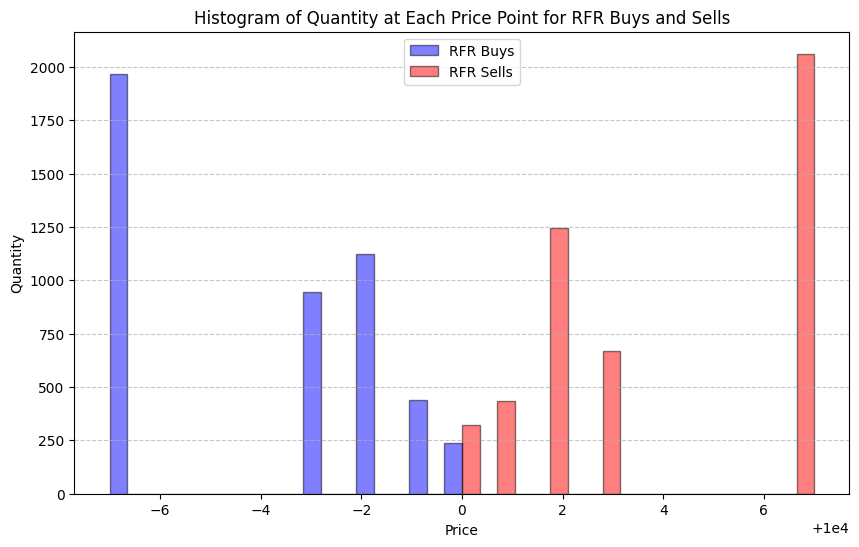

In [63]:
# Extract price and quantity data for rfr_buys and rfr_sells
buy_prices = [trade.price for trade in rfr_buys]
buy_quantities = [trade.quantity for trade in rfr_buys]

sell_prices = [trade.price for trade in rfr_sells]
sell_quantities = [trade.quantity for trade in rfr_sells]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(buy_prices, weights=buy_quantities, bins=20, edgecolor='black', alpha=0.5, label='RFR Buys', color='blue')
plt.hist(sell_prices, weights=sell_quantities, bins=20, edgecolor='black', alpha=0.5, label='RFR Sells', color='red')
plt.title('Histogram of Quantity at Each Price Point for RFR Buys and Sells')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [64]:
rfr_bot_trades = [trade for trade in rfr_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
kelp_bot_trades = [trade for trade in kelp_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
squid_ink_bot_trades = [trade for trade in squid_ink_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
croissants_bot_trades = [trade for trade in croissants_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
jams_bot_trades = [trade for trade in jams_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
djembes_bot_trades = [trade for trade in djembes_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
pic1_bot_trades = [trade for trade in pic1_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
pic2_bot_trades = [trade for trade in pic2_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']

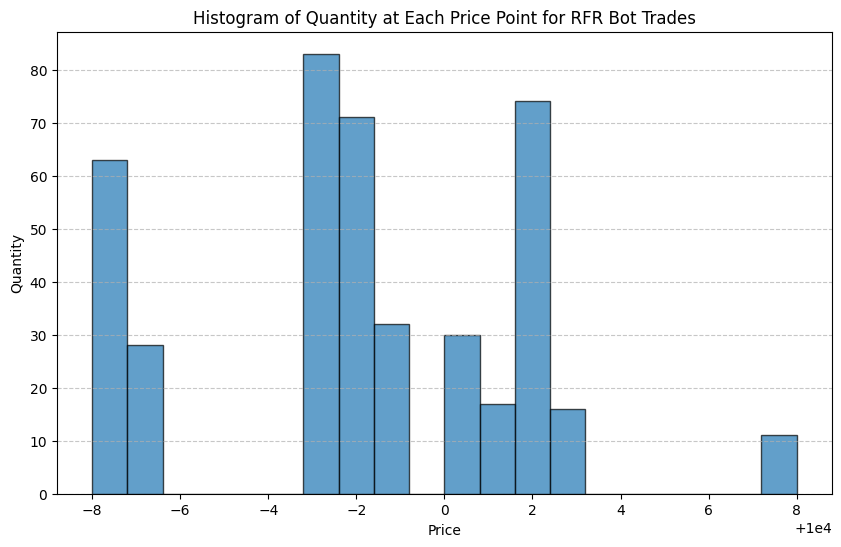

In [65]:
import matplotlib.pyplot as plt

# Extract price and quantity data
prices = [trade.price for trade in rfr_bot_trades]
quantities = [trade.quantity for trade in rfr_bot_trades]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(prices, weights=quantities, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Quantity at Each Price Point for RFR Bot Trades')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

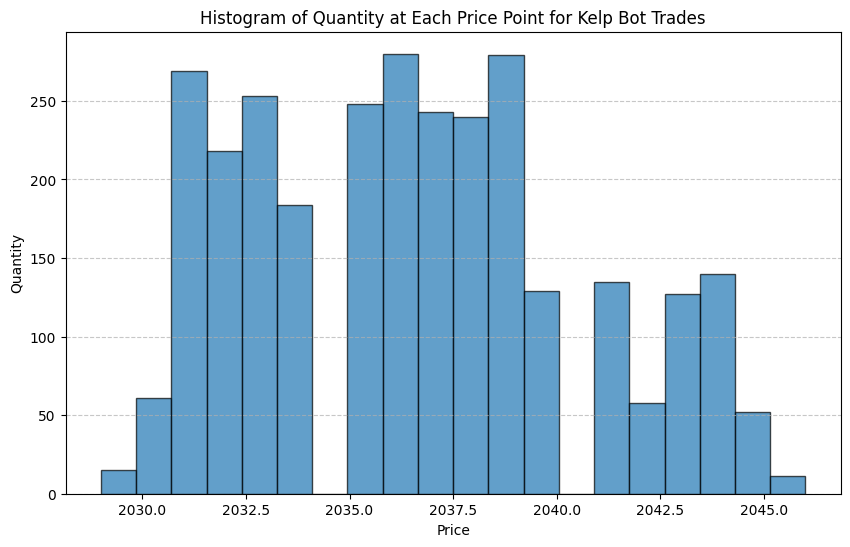

In [66]:

# Extract price and quantity data
prices = [trade.price for trade in kelp_bot_trades]
quantities = [trade.quantity for trade in kelp_bot_trades]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(prices, weights=quantities, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Quantity at Each Price Point for Kelp Bot Trades')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

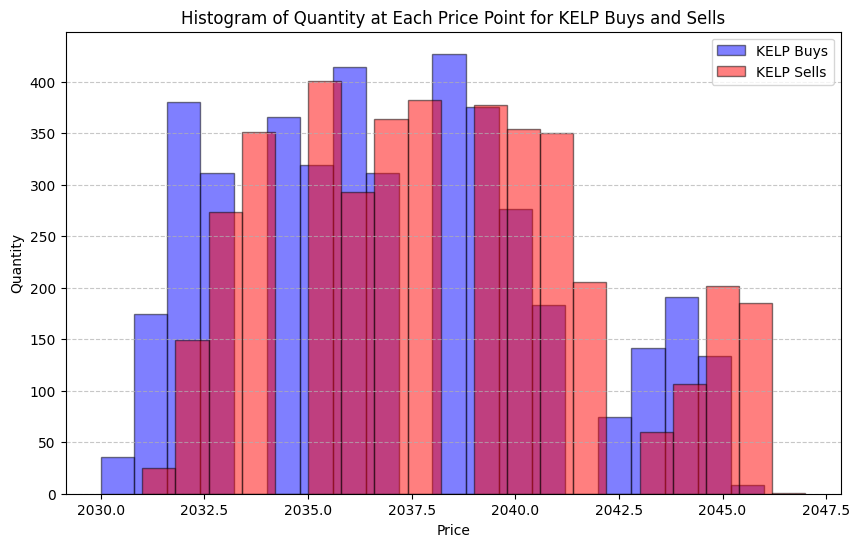

In [67]:
# Extract price and quantity data for rfr_buys and rfr_sells
buy_prices = [trade.price for trade in kelp_buys]
buy_quantities = [trade.quantity for trade in kelp_buys]

sell_prices = [trade.price for trade in kelp_sells]
sell_quantities = [trade.quantity for trade in kelp_sells]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(buy_prices, weights=buy_quantities, bins=20, edgecolor='black', alpha=0.5, label='KELP Buys', color='blue')
plt.hist(sell_prices, weights=sell_quantities, bins=20, edgecolor='black', alpha=0.5, label='KELP Sells', color='red')
plt.title('Histogram of Quantity at Each Price Point for KELP Buys and Sells')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [68]:
rfr_pnl = - sum([trade.price * trade.quantity for trade in rfr_buys]) + sum([trade.price * trade.quantity for trade in rfr_sells])
print(f"RFR PnL: {rfr_pnl}")

kelp_pnl = - sum([trade.price * trade.quantity for trade in kelp_buys]) + sum([trade.price * trade.quantity for trade in kelp_sells])
print(f"Kelp PnL: {kelp_pnl}")

squid_ink_pnl = - sum([trade.price * trade.quantity for trade in squid_ink_buys]) + sum([trade.price * trade.quantity for trade in squid_ink_sells])
print(f"Squid Ink PnL: {squid_ink_pnl}")

croissants_pnl = - sum([trade.price * trade.quantity for trade in croissants_buys]) + sum([trade.price * trade.quantity for trade in croissants_sells])
print(f"Croissants PnL: {croissants_pnl}")

jams_pnl = - sum([trade.price * trade.quantity for trade in jams_buys]) + sum([trade.price * trade.quantity for trade in jams_sells])
print(f"Jams PnL: {jams_pnl}")

djembes_pnl = - sum([trade.price * trade.quantity for trade in djembes_buys]) + sum([trade.price * trade.quantity for trade in djembes_sells])
print(f"Djembes PnL: {djembes_pnl}")

pic1_pnl = - sum([trade.price * trade.quantity for trade in pic1_buys]) + sum([trade.price * trade.quantity for trade in pic1_sells])
print(f"Picnic Basket 1 PnL: {pic1_pnl}")

pic2_pnl = - sum([trade.price * trade.quantity for trade in pic2_buys]) + sum([trade.price * trade.quantity for trade in pic2_sells])
print(f"Picnic Basket 2 PnL: {pic2_pnl}")

volcanic_pnl = - sum([trade.price * trade.quantity for trade in volcanic_buys]) + sum([trade.price * trade.quantity for trade in volcanic_sells])
print(f"Volcanic Rock PnL: {volcanic_pnl}")

volcanic_rock_voucher_9500_pnl = - sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_9500_buys]) + sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_9500_sells])
print(f"Volcanic Rock Voucher 9500 PnL: {volcanic_rock_voucher_9500_pnl}")

volcanic_rock_voucher_9750_pnl = - sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_9750_buys]) + sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_9750_sells])
print(f"Volcanic Rock Voucher 9750 PnL: {volcanic_rock_voucher_9750_pnl}")

volcanic_rock_voucher_10000_pnl = - sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10000_buys]) + sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10000_sells])
print(f"Volcanic Rock Voucher 10000 PnL: {volcanic_rock_voucher_10000_pnl}")

volcanic_rock_voucher_10250_pnl = - sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10250_buys]) + sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10250_sells])
print(f"Volcanic Rock Voucher 10250 PnL: {volcanic_rock_voucher_10250_pnl}")

volcanic_rock_voucher_10500_pnl = - sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10500_buys]) + sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10500_sells])
print(f"Volcanic Rock Voucher 10500 PnL: {volcanic_rock_voucher_10500_pnl}")

total_realised_pnl = rfr_pnl + kelp_pnl + squid_ink_pnl + croissants_pnl + jams_pnl + djembes_pnl + pic1_pnl + pic2_pnl\
                        + volcanic_pnl + volcanic_rock_voucher_9500_pnl + volcanic_rock_voucher_9750_pnl + volcanic_rock_voucher_10000_pnl\
                        + volcanic_rock_voucher_10250_pnl + volcanic_rock_voucher_10500_pnl

print(f"Total Realised PnL: {total_realised_pnl}")

total_pnl = total_realised_pnl + total_outstanding_position_value
print(f"Total PnL: {total_pnl}")

RFR PnL: 238651
Kelp PnL: -80517
Squid Ink PnL: 0
Croissants PnL: 0
Jams PnL: 0
Djembes PnL: 0
Picnic Basket 1 PnL: 0
Picnic Basket 2 PnL: 0
Volcanic Rock PnL: 6107226
Volcanic Rock Voucher 9500 PnL: 132605
Volcanic Rock Voucher 9750 PnL: 83433
Volcanic Rock Voucher 10000 PnL: 36763
Volcanic Rock Voucher 10250 PnL: 7433
Volcanic Rock Voucher 10500 PnL: -9004
Total Realised PnL: 6516590
Total PnL: 312951.5


In [69]:
# basket realised arb pnl
basket_arb_pnl = croissants_pnl + jams_pnl + djembes_pnl + pic1_pnl + pic2_pnl
# unrealised arb 
basket_arb_unrlzd_pnl = (
    outstanding_croissants_position * activities_df[activities_df['product'] == 'CROISSANTS']['mid_price'].iloc[-1] +
    outstanding_djembes_position * activities_df[activities_df['product'] == 'DJEMBES']['mid_price'].iloc[-1] +
    outstanding_jams_position * activities_df[activities_df['product'] == 'JAMS']['mid_price'].iloc[-1] +
    outstanding_pic1_position * activities_df[activities_df['product'] == 'PICNIC_BASKET1']['mid_price'].iloc[-1] +
    outstanding_pic2_position * activities_df[activities_df['product'] == 'PICNIC_BASKET2']['mid_price'].iloc[-1]
)
total_basket_arb_pnl = basket_arb_pnl + basket_arb_unrlzd_pnl
print(f"Basket Arb PnL: {basket_arb_pnl}")
print(f"Basket Arb Unrealised PnL: {basket_arb_unrlzd_pnl}")
print(f"Total Basket Arb PnL: {total_basket_arb_pnl}")






Basket Arb PnL: 0
Basket Arb Unrealised PnL: 0.0
Total Basket Arb PnL: 0.0
